In [1]:
#environment_name = binance_api

### 0. Import Dependencies

In [4]:
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
# binance documentation: https://python-binance.readthedocs.io/en/latest/
import pandas as pd
import numpy as np
from alpha_vantage.timeseries import TimeSeries
import requests
import json
import datetime
from functools import reduce
import datetime

### 1. Binance API creds Setup

In [5]:
#password management with binance secret key
with open('projectscrapepeewee.txt', 'r') as f:
    pw = f.read()

In [6]:
#setting up API creds
apikey = 'insert API key here'
secret = pw #string from .txt goes here

In [7]:
#setup and connect to client and auth binance
client = Client(apikey, secret)

### 2. AlphaVantage API creds setup

In [8]:
av_api = 'insert API key here'

In [9]:
ethscan_api = 'insert API key here'

### 3. Inputs for creating DF

In [10]:
binance_ticker = 'BTCUSDT'

In [11]:
binance_start_dt = '1 Jan 2019'

### 4. Function to create/export dataframes

In [12]:
def create_frames(binance_ticker, binance_start_dt):
    #create global df for ouput
    global df
    
    #BINANCE API
    #create frame showing ticker 1min chart data, based on ticker and start data
    binance_historical = client.get_historical_klines(binance_ticker, Client.KLINE_INTERVAL_1DAY, binance_start_dt)
    binance_df = pd.DataFrame(binance_historical)
    #rename columns to something readable
    binance_df.columns=['open_time',binance_ticker+'_open', binance_ticker+'_high', binance_ticker+'_low', binance_ticker+'_close', binance_ticker+'_volume', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol','is_best_match']
    #date time cols to datetime format
    binance_df['open_time'] = pd.to_datetime(binance_df['open_time']/1000, unit='s')
    binance_df['close_time'] = pd.to_datetime(binance_df['close_time']/1000, unit='s')
    #numeric cols to numeric format
    numeric_cols = [binance_ticker+'_open', binance_ticker+'_high', binance_ticker+'_low', binance_ticker+'_close', binance_ticker+'_volume', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'is_best_match']
    binance_df[numeric_cols] = binance_df[numeric_cols].apply(pd.to_numeric)
    #create date column on right for merging
    binance_df['date'] = binance_df['open_time'].dt.date
    binance_df['date'] = pd.to_datetime(binance_df['date'])
    #flip dates around
    binance_df.sort_values(by='open_time', ascending=True, inplace=True)
    
    #ALPHA VANTAGE API
    #Invesco DB US Dollar Index Bullish Fund as a proxy for USD index
    usd_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=UUP&apikey={av_api}'
    r_usd = requests.get(usd_url)
    usd_df = r_usd.json()
    usd_df = pd.DataFrame(usd_df['Time Series (Daily)']).T
    usd_df.reset_index(inplace=True)
    usd_df = usd_df.rename(columns={'index':'date','4. close':'usd_close'})
    usd_df = usd_df[['date', 'usd_close']]
    usd_df['date'] = pd.to_datetime(usd_df['date'])
    usd_df['usd_close'] = usd_df['usd_close'].apply(pd.to_numeric)
    
    #SPY as proxy for S&P500
    spy_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&apikey={av_api}'
    spy_r = requests.get(spy_url)
    spy_df = spy_r.json()
    spy_df = pd.DataFrame(spy_df['Time Series (Daily)']).T    
    spy_df.reset_index(inplace=True)
    spy_df = spy_df.rename(columns={'index':'date','4. close':'spy_close'})
    spy_df = spy_df[['date', 'spy_close']]
    spy_df['date'] = pd.to_datetime(spy_df['date'])
    spy_df['spy_close'] = spy_df['spy_close'].apply(pd.to_numeric)
    
    #Chinese stock market proxy
    ftse_china_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AH50.LON&outputsize=full&apikey={av_api}'
    ftse_china_r = requests.get(ftse_china_url)
    ftse_china_df = ftse_china_r.json()
    ftse_china_df = pd.DataFrame(ftse_china_df['Time Series (Daily)']).T    
    ftse_china_df.reset_index(inplace=True)
    ftse_china_df = ftse_china_df.rename(columns={'index':'date','4. close':'ftse_china_close'})
    ftse_china_df = ftse_china_df[['date', 'ftse_china_close']]
    ftse_china_df['date'] = pd.to_datetime(ftse_china_df['date'])
    ftse_china_df['ftse_china_close'] = ftse_china_df['ftse_china_close'].apply(pd.to_numeric)
    
    #gold prices proxy
    gld_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GLD&apikey={av_api}'
    gld_r = requests.get(gld_url)
    gld_df = gld_r.json()
    gld_df = pd.DataFrame(gld_df['Time Series (Daily)']).T    
    gld_df.reset_index(inplace=True)
    gld_df = gld_df.rename(columns={'index':'date','4. close':'gld_close'})
    gld_df = gld_df[['date', 'gld_close']]
    gld_df['date'] = pd.to_datetime(gld_df['date'])
    gld_df['gld_close'] = gld_df['gld_close'].apply(pd.to_numeric)
    
    #non-farm payrolls
    nfp_url = f'https://www.alphavantage.co/query?function=NONFARM_PAYROLL&apikey={av_api}'
    nfp_r = requests.get(nfp_url)
    nfp_df = nfp_r.json()
    nfp_df = pd.DataFrame(nfp_df['data'])
    nfp_df = nfp_df.rename(columns={'value':'nfp_close'})
    nfp_df['date'] = pd.to_datetime(nfp_df['date'])
    nfp_df['nfp_close'] = nfp_df['nfp_close'].apply(pd.to_numeric)
    
    #btc daily transaction vol (confirmed blocks) from blockchain info. to see onchain txn
    #source: https://www.blockchain.com/charts/estimated-transaction-volume-usd
    #note: The total estimated value in USD of transactions on the blockchain. This does not include coins returned as change.
    #steps:1. inspect elements 2. look for files marked json under network tab 3. scrape
    btc_txn_vol_url = 'https://api.blockchain.info/charts/estimated-transaction-volume-usd?timespan=all&sampled=true&metadata=false&cors=true&format=json'
    btc_txn_vol = requests.get(btc_txn_vol_url).json()
    btc_txn_df = pd.DataFrame(btc_txn_vol['values'])
    btc_txn_df = btc_txn_df.rename(columns={'x':'date','y':'btc_txn_vol'})
    btc_txn_df['date'] = pd.to_datetime(btc_txn_df['date'],unit='s')
    btc_txn_df.sort_values(by='date', ascending=True, inplace=True)
    
    #btc number of unique wallets on blockchain
    #source: https://www.blockchain.com/charts/my-wallet-n-users
    #note: The total number of unique Blockchain.com wallets created.
    #steps:1. inspect elements 2. look for files marked json under network tab 3. scrape    
    btc_wallet_unique_url = 'https://api.blockchain.info/charts/my-wallet-n-users?timespan=all&sampled=true&metadata=false&cors=true&format=json'
    btc_wallet_unique = requests.get(btc_wallet_unique_url).json()
    btc_wallet_unique_df = pd.DataFrame(btc_wallet_unique['values'])
    btc_wallet_unique_df = btc_wallet_unique_df.rename(columns={'x':'date','y':'btc_wallet_unique'})
    btc_wallet_unique_df['date'] = pd.to_datetime(btc_wallet_unique_df['date'],unit='s')
    btc_wallet_unique_df.sort_values(by='date', ascending=True, inplace=True)
    btc_wallet_unique_df['date'] = btc_wallet_unique_df['date'].dt.date
    btc_wallet_unique_df['date'] = pd.to_datetime(btc_wallet_unique_df['date'])
    
    
    #btc daily Average Block Size (MB)
    #source: https://www.blockchain.com/charts/estimated-transaction-volume-usd
    #note: The average block size over the past 24 hours in megabytes.
    #steps:1. inspect elements 2. look for files marked json under network tab 3. scrape
    btc_blk_size_url = 'https://api.blockchain.info/charts/avg-block-size?timespan=all&sampled=true&metadata=false&cors=true&format=json'
    btc_blk_size = requests.get(btc_blk_size_url).json()
    btc_blk_size_df = pd.DataFrame(btc_blk_size['values'])
    btc_blk_size_df = btc_blk_size_df.rename(columns={'x':'date','y':'btc_blk_size_mb'})
    btc_blk_size_df['date'] = pd.to_datetime(btc_blk_size_df['date'],unit='s')
    btc_blk_size_df.sort_values(by='date', ascending=True, inplace=True)
    btc_blk_size_df['date'] = btc_blk_size_df['date'].dt.date
    btc_blk_size_df['date'] = pd.to_datetime(btc_blk_size_df['date'])


    #merge df's
    # compile the list of dataframes you want to merge
    data_frames = [binance_df, usd_df, spy_df, ftse_china_df, gld_df, nfp_df, btc_txn_df, btc_wallet_unique_df, btc_blk_size_df]
    #merge list of dataframes from above
    df = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='left'), data_frames)
    
    #ffill df NaN values
    #forward fill to fill null values with previous values
    df['usd_close'] = df['usd_close'].ffill()
    df['spy_close'] = df['spy_close'].ffill()
    df['ftse_china_close'] = df['ftse_china_close'].ffill()
    df['gld_close'] = df['gld_close'].ffill()
    df['nfp_close'] = df['nfp_close'].ffill()
    df['btc_txn_vol'] = df['btc_txn_vol'].ffill()
    df['btc_wallet_unique'] = df['btc_wallet_unique'].ffill()
    df['btc_blk_size_mb'] = df['btc_blk_size_mb'].ffill()
    
    ###change datetime values to int
    #add year, day of month, day of month,week,year columns
    df['year'] = pd.DatetimeIndex(df['close_time']).year
    df['month'] = pd.DatetimeIndex(df['close_time']).month
    df['date_of_month'] = pd.DatetimeIndex(df['close_time']).day
    df['day_of_week'] = pd.DatetimeIndex(df['close_time']).dayofweek
    df['day_of_year'] = pd.DatetimeIndex(df['close_time']).dayofyear
    df['hour_of_day'] = pd.DatetimeIndex(df['close_time']).hour
    df['hour_of_day'] = pd.DatetimeIndex(df['close_time']).minute
    
    #del datetime format columns except close time. we keep that for looking back
#     del df['open_time']
#     del df['close_time']

    #df.fillna(method='ffill', inplace=True) #not working for some reason, above achieves same
    return df

***
Focus here was to get good data. Good resolution on data. Process it before we can find patterns that can hopefully predict an output. Will trial randomforest bagging, regular linear regressions, and neural networks to see if we can find anything and make a usable model.
***

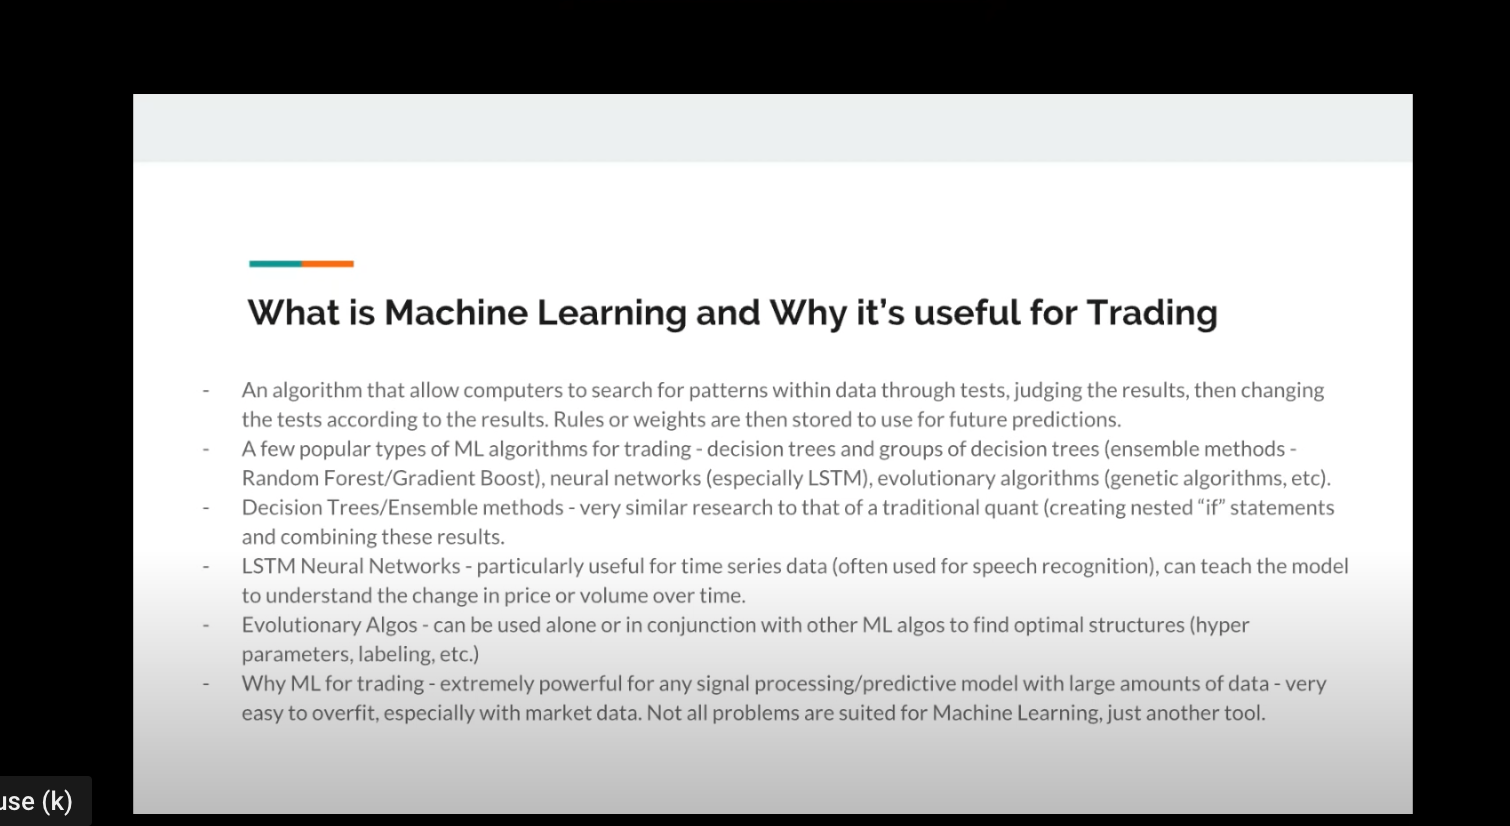

In [13]:
create_frames(binance_ticker, binance_start_dt)

,open_time,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume,close_time,qav,num_trades,taker_base_vol,...,nfp_close,btc_txn_vol,btc_wallet_unique,btc_blk_size_mb,year,month,date_of_month,day_of_week,day_of_year,hour_of_day
0,2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,2019-01-01 23:59:59.999000064,8.814925e+07,154227,12919.155899,...,147879.0,NaN,31920413.0,0.801779,2019,1,1,1,1,59
1,2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,2019-01-02 23:59:59.999000064,1.338766e+08,218538,17921.600114,...,147879.0,NaN,31931109.0,0.801779,2019,1,2,2,2,59
2,2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,2019-01-03 23:59:59.999000064,1.116574e+08,199812,14793.083267,...,147879.0,5.863351e+08,31965924.0,0.801779,2019,1,3,3,3,59
3,2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,2019-01-04 23:59:59.999000064,1.110346e+08,192232,15579.303258,...,147879.0,5.863351e+08,31983139.0,0.959199,2019,1,4,4,4,59
4,2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,2019-01-04 23:59:59.999000064,1.110346e+08,192232,15579.303258,...,147879.0,5.863351e+08,32105412.0,0.959199,2019,1,4,4,4,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,2021-09-20,47241.75,47347.25,42500.00,43015.62,78003.524443,2021-09-20 23:59:59.999000064,3.457139e+09,1842231,36108.362951,...,146856.0,1.797163e+09,76764696.0,1.214339,2021,9,20,0,263,59
1186,2021-09-21,43016.64,43639.00,39600.00,40734.38,84534.080485,2021-09-21 23:59:59.999000064,3.551998e+09,1820721,38942.743560,...,146856.0,1.797163e+09,76781174.0,1.214339,2021,9,21,1,264,59
1187,2021-09-22,40734.09,44000.55,40565.39,43543.61,58349.055420,2021-09-22 23:59:59.999000064,2.482639e+09,1304011,29321.506600,...,146856.0,3.589502e+09,76800690.0,1.214339,2021,9,22,2,265,59
1188,2021-09-23,43546.37,44978.00,43069.09,44865.26,48699.576550,2021-09-23 23:59:59.999000064,2.147211e+09,1196106,24503.003650,...,146856.0,3.589502e+09,76810295.0,1.016578,2021,9,23,3,266,59


In [16]:
#save this df to pickle output. sep 1Jan2019 to 24Sep2021, 1d candles
df.to_pickle('btcusdt_1d_ohlcv_av_1Jan2019_to_24Sep2021_1day.pkl')

In [15]:
df.dtypes

open_time            datetime64[ns]
BTCUSDT_open                float64
BTCUSDT_high                float64
BTCUSDT_low                 float64
BTCUSDT_close               float64
BTCUSDT_volume              float64
close_time           datetime64[ns]
qav                         float64
num_trades                    int64
taker_base_vol              float64
taker_quote_vol             float64
is_best_match                 int64
date                 datetime64[ns]
usd_close                   float64
spy_close                   float64
ftse_china_close            float64
gld_close                   float64
nfp_close                   float64
btc_txn_vol                 float64
btc_wallet_unique           float64
btc_blk_size_mb             float64
year                          int64
month                         int64
date_of_month                 int64
day_of_week                   int64
day_of_year                   int64
hour_of_day                   int64
dtype: object

In [15]:
#save this df to pickle output. sep 22 data 1 day data
df.to_pickle('btcusdt_min_ohlcv_av_22Sep2021_1day.pkl')

In [28]:
#save this df to pickle output. Jan1-Sep16 Data
df.to_pickle('btcusdt_min_ohlcv_av_btcblock_Jan2019ToSep2021.pkl')

In [29]:
btc_df = pd.read_pickle('btcusdt_min_ohlcv_av_btcblock_Jan2019ToSep2021.pkl')

follow general steps on: https://www.youtube.com/watch?v=CwcPFUpnjms

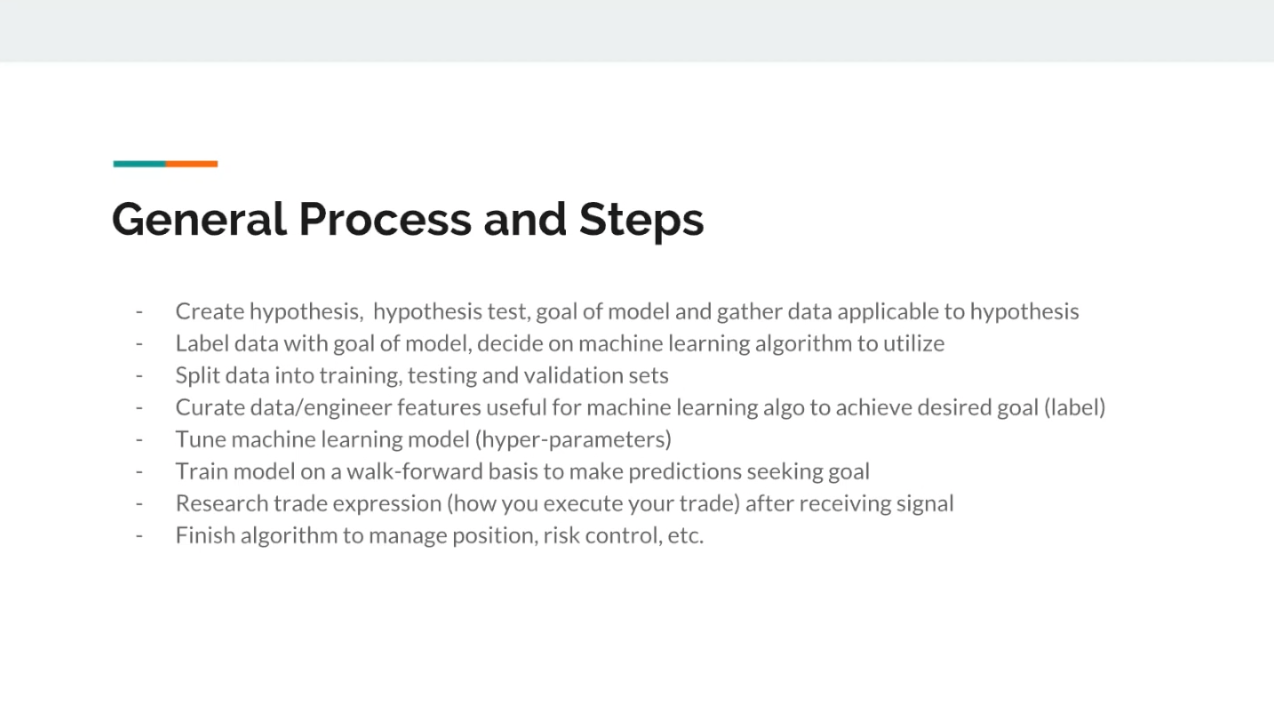

- inspired by : https://www.sciencedirect.com/science/article/pii/S2405918821000027

- Create hypothesis: Adaptive market hypothesis holds for bitcoin markets. EMH, argues that markets are not rational, but rather driven by fear and greed. First, we contribute to the literature by systematically comparing the predictive capability of different prediction models (e.g., recurrent neural networks, gradient boosting classifiers), feature sets (e.g., technical, blockchain-based), and prediction horizons (1–60 min). Thereby, our study establishes a thorough benchmark for the predictive accuracy of short-term bitcoin market prediction models. The general picture emerging from the analysis is that recurrent neural networks and gradient boosting classifiers appear well-suited for this prediction problem and technical features remain most-relevant. Also, an interesting side finding is that, for longer prediction horizons, prediction accuracy tends to increase and less recent features appear to be of particular importance.
https://jpm.pm-research.com/content/30/5/15

In [ ]:
#save this df to output. Jan1-Sep16 Data
df.to_csv('btcusdt_min_ohlcv_av_btcblock_JanToSep.csv', index=False)

"""

According to the Binance API documentation, there is no option to get historical data on the order book. Therefore there should be no option in python-binance either.

In the documentation, I see the following (nearest) endpoints:

    Order Book: Current order book for a selected symbol.
    
    Old Trade Lookup: If you want to collect all historical trades (but without the bid/ask prices).
    
    Symbol Order Book Ticker: Best (current) price/qty on the order book for a symbol or symbols.

"""

***
We should still look for a way to implement this in the websocket query to calculate all in cost for the trades. Above data could be for initial analysis/EDA/model building
***

### Next steps:
1. Normalize data
2. Build multiple models (arima, keras, pycaret regression) + train/test
3. Measure scoring metrics
4. Plot trades for winning models
5. Execution .py script 

